In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os
from spec_augment_pytorch import spec_augment
import librosa
import numpy as np

C:\Users\ricky\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


# load X and SpecAugment

In [2]:
def load_X(augment=False):
    wav_dir = 'train/train/'
    files = os.listdir(wav_dir)
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            # load raw audio
            audio, sampling_rate = librosa.load(wav_dir+f)
            # caculate 3 type features
            mel_spectrogram = np.expand_dims(librosa.feature.melspectrogram(y=audio,sr=sampling_rate,n_mels=256,hop_length=128,fmax=8000), axis=0)
            delta1_mel_spectrogram = librosa.feature.delta(mel_spectrogram, order=1)
            delta2_mel_spectrogram = librosa.feature.delta(mel_spectrogram, order=2)
            # if augment ??
            if augment == True:
                mel_spectrogram = spec_augment(mel_spectrogram=torch.from_numpy(mel_spectrogram))
            # stacked 3 type feature
            features = np.concatenate((mel_spectrogram, delta1_mel_spectrogram, delta2_mel_spectrogram), axis=0) 
            # convert to torch tensor and reshape to [B,C,M,N]
            shape = features.shape
            features = torch.from_numpy(np.reshape(features, (-1, shape[0], shape[1],shape[2])))
            # append to X
            X = torch.cat([X,features],dim = 0)
        except:
            print(f,'the file have problem')
            pass
    return X

In [3]:
X_without_specaugment = load_X(augment=False)
X_specaugment = load_X(augment=True)
print(X_without_specaugment.shape)
print(X_specaugment.shape)

train_01046.wav the file have problem



train_01046.wav the file have problem

torch.Size([1199, 3, 256, 862])
torch.Size([1199, 3, 256, 862])


# load data Y

In [4]:
Y = pd.read_csv('train\meta_train.csv',index_col='Filename')
Y = Y[Y.index != 'train_01046']
print(Y.shape)
Y.head()

(1199, 2)


,Label,Remark
Filename,,
train_00001,0,Barking
train_00002,0,Barking
train_00003,0,Barking
train_00004,0,Barking
train_00005,0,Barking


In [5]:
Y.Label.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

5    200
3    200
2    200
1    200
0    200
4    199
Name: Label, dtype: int64


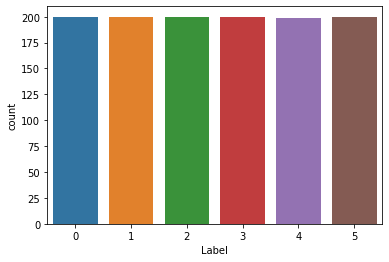

In [6]:
import seaborn as sns
g = sns.countplot(Y['Label'])
print(Y['Label'].value_counts())

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(Y[['Label']])
Y_one_hot = enc.transform(Y[['Label']]).toarray()
print(Y_one_hot.shape)
Y_one_hot

(1199, 6)


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

# look some sample

['Barking' 'Howling' 'Crying' 'COSmoke' 'GlassBreaking' 'Other' 'Vacuum'
 'Blender' 'Electrics' 'Cat' 'Dishes'] 11


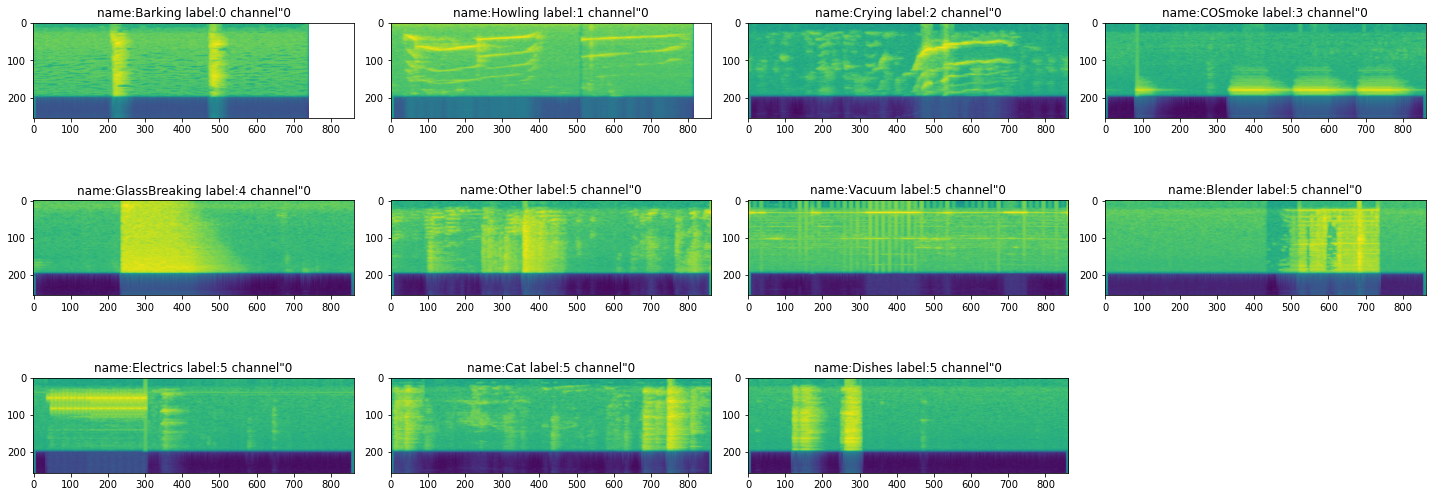

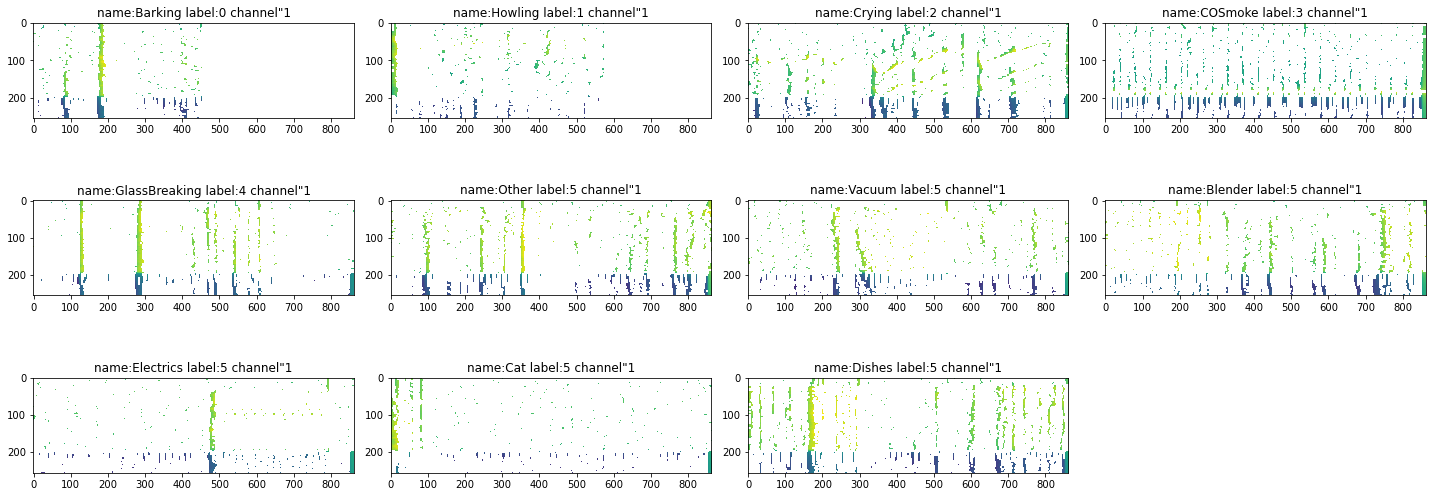

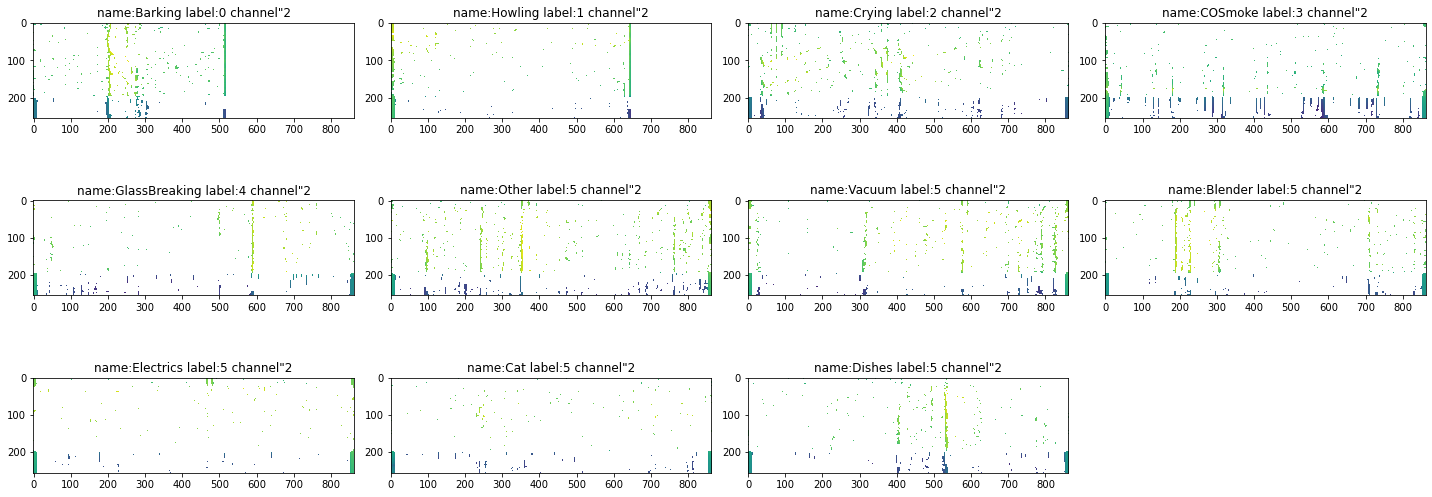

In [9]:
print(Y.Remark.unique(),len(Y.Remark.unique()))
for c in [0,1,2]:
    plt.figure(figsize=(20,10))
    for j,i in enumerate(Y.Remark.unique()):
        sample = Y[Y.Remark==i].sample(1)
        idx = sample.index[0]
        label = sample['Label'][0]
        idx = int(idx.split('_')[1])
        plt.subplot(4,4,j+1)
        plt.imshow(X_without_specaugment[idx,c,:,:].log2()) # log2方便觀察
        title = 'name:{} label:{} channel"{}'.format(i,label,c)
        plt.title(title)
    plt.tight_layout()
    plt.show()

['Barking' 'Howling' 'Crying' 'COSmoke' 'GlassBreaking' 'Other' 'Vacuum'
 'Blender' 'Electrics' 'Cat' 'Dishes'] 11


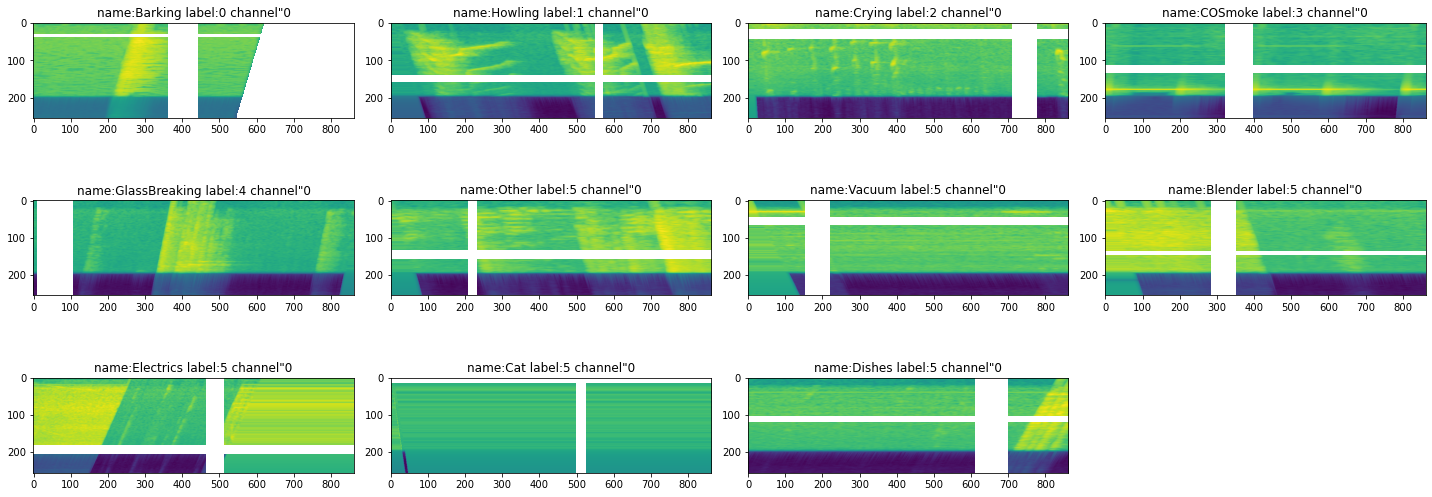

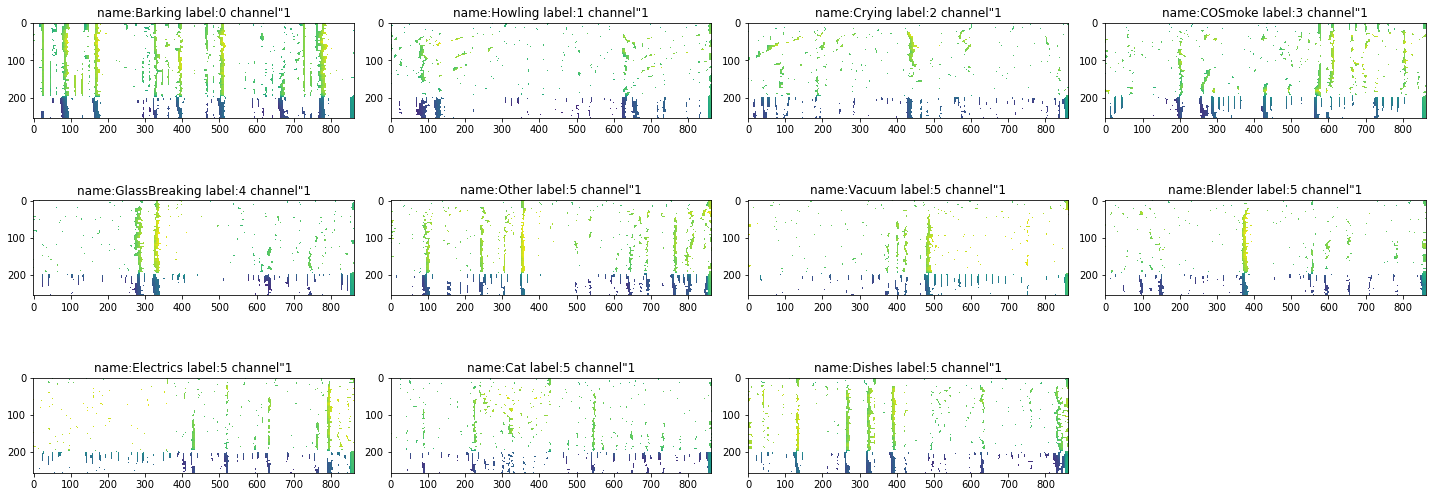

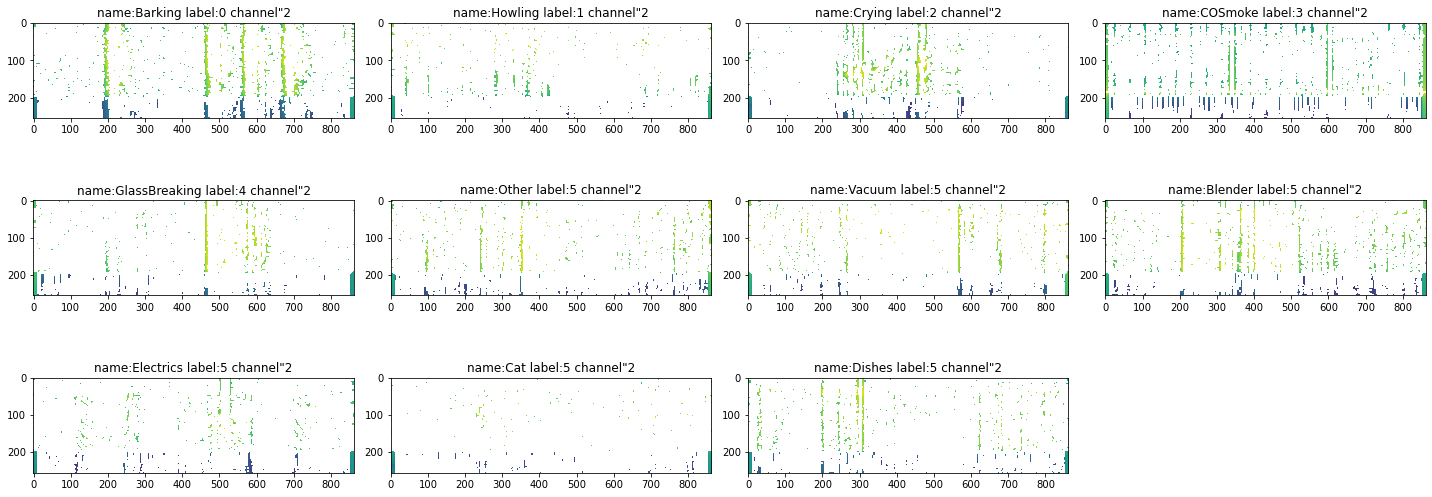

In [10]:
print(Y.Remark.unique(),len(Y.Remark.unique()))
for c in [0,1,2]:
    plt.figure(figsize=(20,10))
    for j,i in enumerate(Y.Remark.unique()):
        sample = Y[Y.Remark==i].sample(1)
        idx = sample.index[0]
        label = sample['Label'][0]
        idx = int(idx.split('_')[1])
        plt.subplot(4,4,j+1)
        plt.imshow(X_specaugment[idx,c,:,:].log2()) # log2方便觀察
        title = 'name:{} label:{} channel"{}'.format(i,label,c)
        plt.title(title)
    plt.tight_layout()
    plt.show()

# merge X_without_augment and X_with_augmet and merge Y_one_hot

In [11]:
X = torch.cat([X_specaugment,X_without_specaugment],dim=0)
X.shape

torch.Size([2398, 3, 256, 862])

In [12]:
Y_one_hot = np.vstack([Y_one_hot,Y_one_hot])
Y_one_hot.shape

(2398, 6)

# create pytorch dataloader and save

In [13]:
from torch.utils.data import TensorDataset,DataLoader
import numpy as np

total_data_len = X.shape[0]
train_percent = 0.8
train_size = int(train_percent*total_data_len)
train_idx = list(np.random.choice([*range(total_data_len)],size=train_size,replace=False))
vaild_idx = list(set([*range(total_data_len)]) - set(train_idx))
trainset = TensorDataset(torch.FloatTensor(X)[train_idx],torch.FloatTensor(Y_one_hot)[train_idx])
vaildset = TensorDataset(torch.FloatTensor(X)[vaild_idx],torch.FloatTensor(Y_one_hot)[vaild_idx])
train_iter = DataLoader(trainset,batch_size=64)
vaild_iter = DataLoader(vaildset,batch_size=64)
torch.save(train_iter, 'train_iter.pt')
torch.save(vaild_iter, 'vaild_iter.pt')